In [1]:
import numpy as np
import pandas as pd

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, column_or_1d
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from tscv import GapKFold

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
# Load used training data

filepath = '../../../data/intermediate/experimentation_train_sets/'

filename = 'train_b_493_m_0_sm_n_t_20200206_193734.csv'

df_features = pd.read_csv(filepath + filename, parse_dates=['timestamp'], index_col=['timestamp'])
df_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8630 entries, 2016-01-01 23:00:00 to 2016-12-31 23:00:00
Data columns (total 7 columns):
day_of_week               8630 non-null int64
day_hour                  8630 non-null int64
dew_temperature_ma_24H    8630 non-null float64
dew_temperature           8630 non-null float64
air_temperature_ma_24H    8630 non-null float64
air_temperature           8630 non-null float64
meter_reading             8630 non-null float64
dtypes: float64(5), int64(2)
memory usage: 539.4 KB


In [3]:
# Build a copy of the train dataset but with 'full index', 
# ie index containing all the hours of the year 2016.

full_date_range = pd.date_range(start='2016-01-01 00:00:00', end='2016-12-31 23:00:00', freq='H')
full_index = pd.DatetimeIndex(full_date_range)

df_full = pd.DataFrame(index=full_index)
for col_name in df_features.columns:
    df_full[col_name] = df_features[col_name]
    
df_full.head(30)

,day_of_week,day_hour,dew_temperature_ma_24H,dew_temperature,air_temperature_ma_24H,air_temperature,meter_reading
2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_to_draw = df_full.copy()
data_to_draw['day_hour'] = data_to_draw.index.to_series().dt.hour
data_to_draw['day_of_week'] = data_to_draw.index.to_series().dt.dayofweek
data_to_draw['day_of_year'] = data_to_draw.index.to_series().dt.dayofyear
data_to_draw['week_of_year'] = data_to_draw.index.to_series().dt.week.mod(53)

In [5]:
df_w1 = data_to_draw[['day_of_year', 'day_hour', 'meter_reading']].copy()
df_w1.reset_index(drop=True, inplace=True)
#df_w1.set_index(['day_of_week'], inplace=True)
df_w1_piv = df_w1.pivot(index='day_of_year', columns='day_hour', values='meter_reading')
df_w1_piv.head()

day_hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_year,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.17
2,297.51,294.78,296.94,294.63,309.42,312.72,380.97,373.38,393.03,397.05,...,345.69,294.48,343.08,350.37,331.68,323.82,325.05,331.20,326.07,284.58
3,295.32,299.25,290.43,296.43,298.74,299.22,373.20,371.49,364.14,357.69,...,311.82,267.18,289.32,313.41,294.84,316.98,322.74,330.09,316.95,296.94
4,301.26,299.13,298.92,297.51,296.94,298.62,400.95,590.88,614.31,564.12,...,370.98,439.29,500.52,501.75,510.54,510.75,496.44,514.89,475.29,332.37
5,308.97,308.61,425.10,428.76,421.41,433.83,467.22,649.35,684.60,645.54,...,455.25,509.40,557.61,552.18,555.12,562.26,495.42,474.27,471.54,299.07


In [6]:
# Set nan values in red
plt.get_cmap('Blues').set_bad('#ea0c0c')

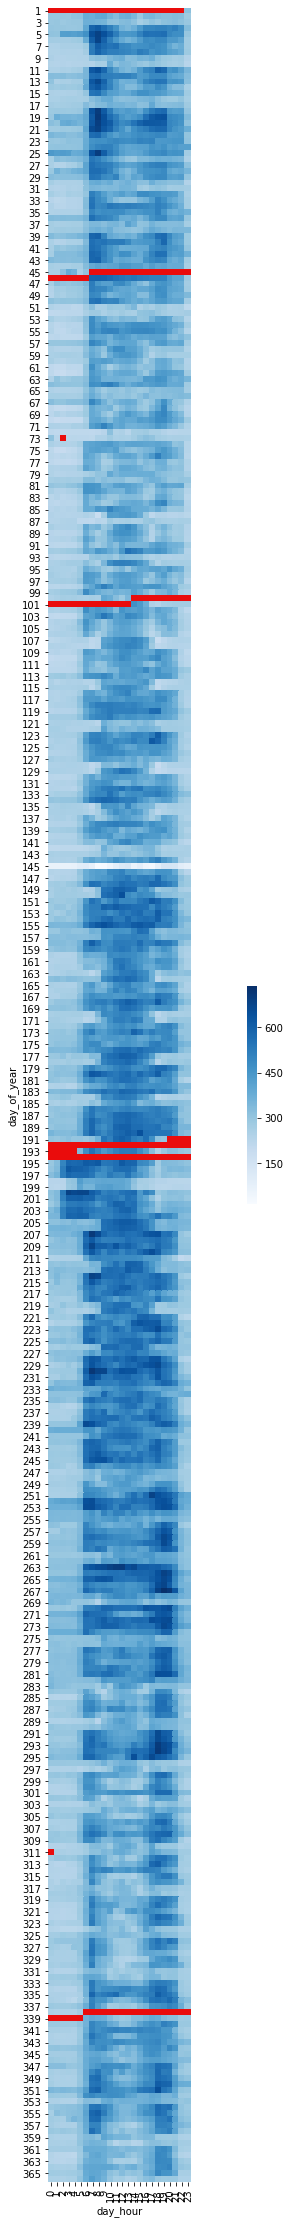

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,40))
sns.heatmap(df_w1_piv, cmap='Blues', cbar_kws={"shrink": 0.1}, square=True, ax=ax)

<b>Entry data</b>

In [8]:
data_folder_path = '../../../data/raw/csvs/'
this_building = 493
this_meter = 0

# Loads building_metadata to get site-building mapping
bdata = pd.read_csv(data_folder_path + 'building_metadata.csv', 
                    index_col='building_id', 
                    usecols=['building_id', 'site_id'])

this_site = bdata.loc[this_building, 'site_id']
print('building is on site {}'.format(this_site))


# Loads meter_reading data
raw_df_meters = pd.read_csv(data_folder_path + 'train.csv', parse_dates=['timestamp'])

to_keep = (raw_df_meters['building_id']==this_building) & (raw_df_meters['meter']==this_meter)
b_df_meters = raw_df_meters[to_keep].copy()

b_df_meters.drop('building_id', axis=1, inplace=True)
b_df_meters.drop('meter', axis=1, inplace=True)

b_df_meters.set_index('timestamp', inplace=True)
b_df_meters.sort_index(inplace=True)

building is on site 3


In [9]:
b_df_meters.head()

,meter_reading
timestamp,
2016-01-01 00:00:00,284.52
2016-01-01 01:00:00,290.52
2016-01-01 02:00:00,292.80
2016-01-01 03:00:00,289.89
2016-01-01 04:00:00,290.01


In [10]:
# Loads weather data
raw_df_weather = pd.read_csv(data_folder_path + 'weather_train.csv', 
                 parse_dates=['timestamp'], index_col=['site_id', 'timestamp'])

b_df_weather = raw_df_weather.loc[(this_site,)]

# keep only air_temperature and dew_temperature
b_df_weather.drop(
    ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'cloud_coverage'],
    axis=1,
    inplace=True
)

# Build time features
b_df_weather['day_hour'] = b_df_weather.index.to_series().dt.hour
b_df_weather['day_of_year'] = b_df_weather.index.to_series().dt.dayofyear

# Builds averaged weather features.

timeframes = [24]
features_to_avg = ['air_temperature', 'dew_temperature']
do_center = False


for c in features_to_avg:
    ts = b_df_weather[c]
    for timeframe in timeframes:
        shifted_ts = ts.rolling(timeframe, center=do_center).mean()
        new_col_name = '' + c + '_ma_' + str(timeframe) + 'H'
        b_df_weather[new_col_name] = shifted_ts

b_df_weather.head()


,air_temperature,dew_temperature,day_hour,day_of_year,air_temperature_ma_24H,dew_temperature_ma_24H
timestamp,,,,,,
2016-01-01 00:00:00,10.0,2.2,0,1,NaN,NaN
2016-01-01 01:00:00,9.4,2.8,1,1,NaN,NaN
2016-01-01 02:00:00,8.9,2.2,2,1,NaN,NaN
2016-01-01 03:00:00,7.8,1.1,3,1,NaN,NaN
2016-01-01 04:00:00,7.8,0.6,4,1,NaN,NaN


In [11]:
weather_features = [
    'air_temperature',
    'air_temperature_ma_24H',
    'dew_temperature',
    'dew_temperature_ma_24H'
]

unindexed_df_weather = b_df_weather.reset_index(drop=True, inplace=False)

pivoted_features = {}

for feature in weather_features:
    df_feature_piv = unindexed_df_weather[[feature, 'day_of_year', 'day_hour']].pivot(
        index='day_of_year', 
        columns='day_hour', 
        values=feature
    )
    pivoted_features[feature] = df_feature_piv

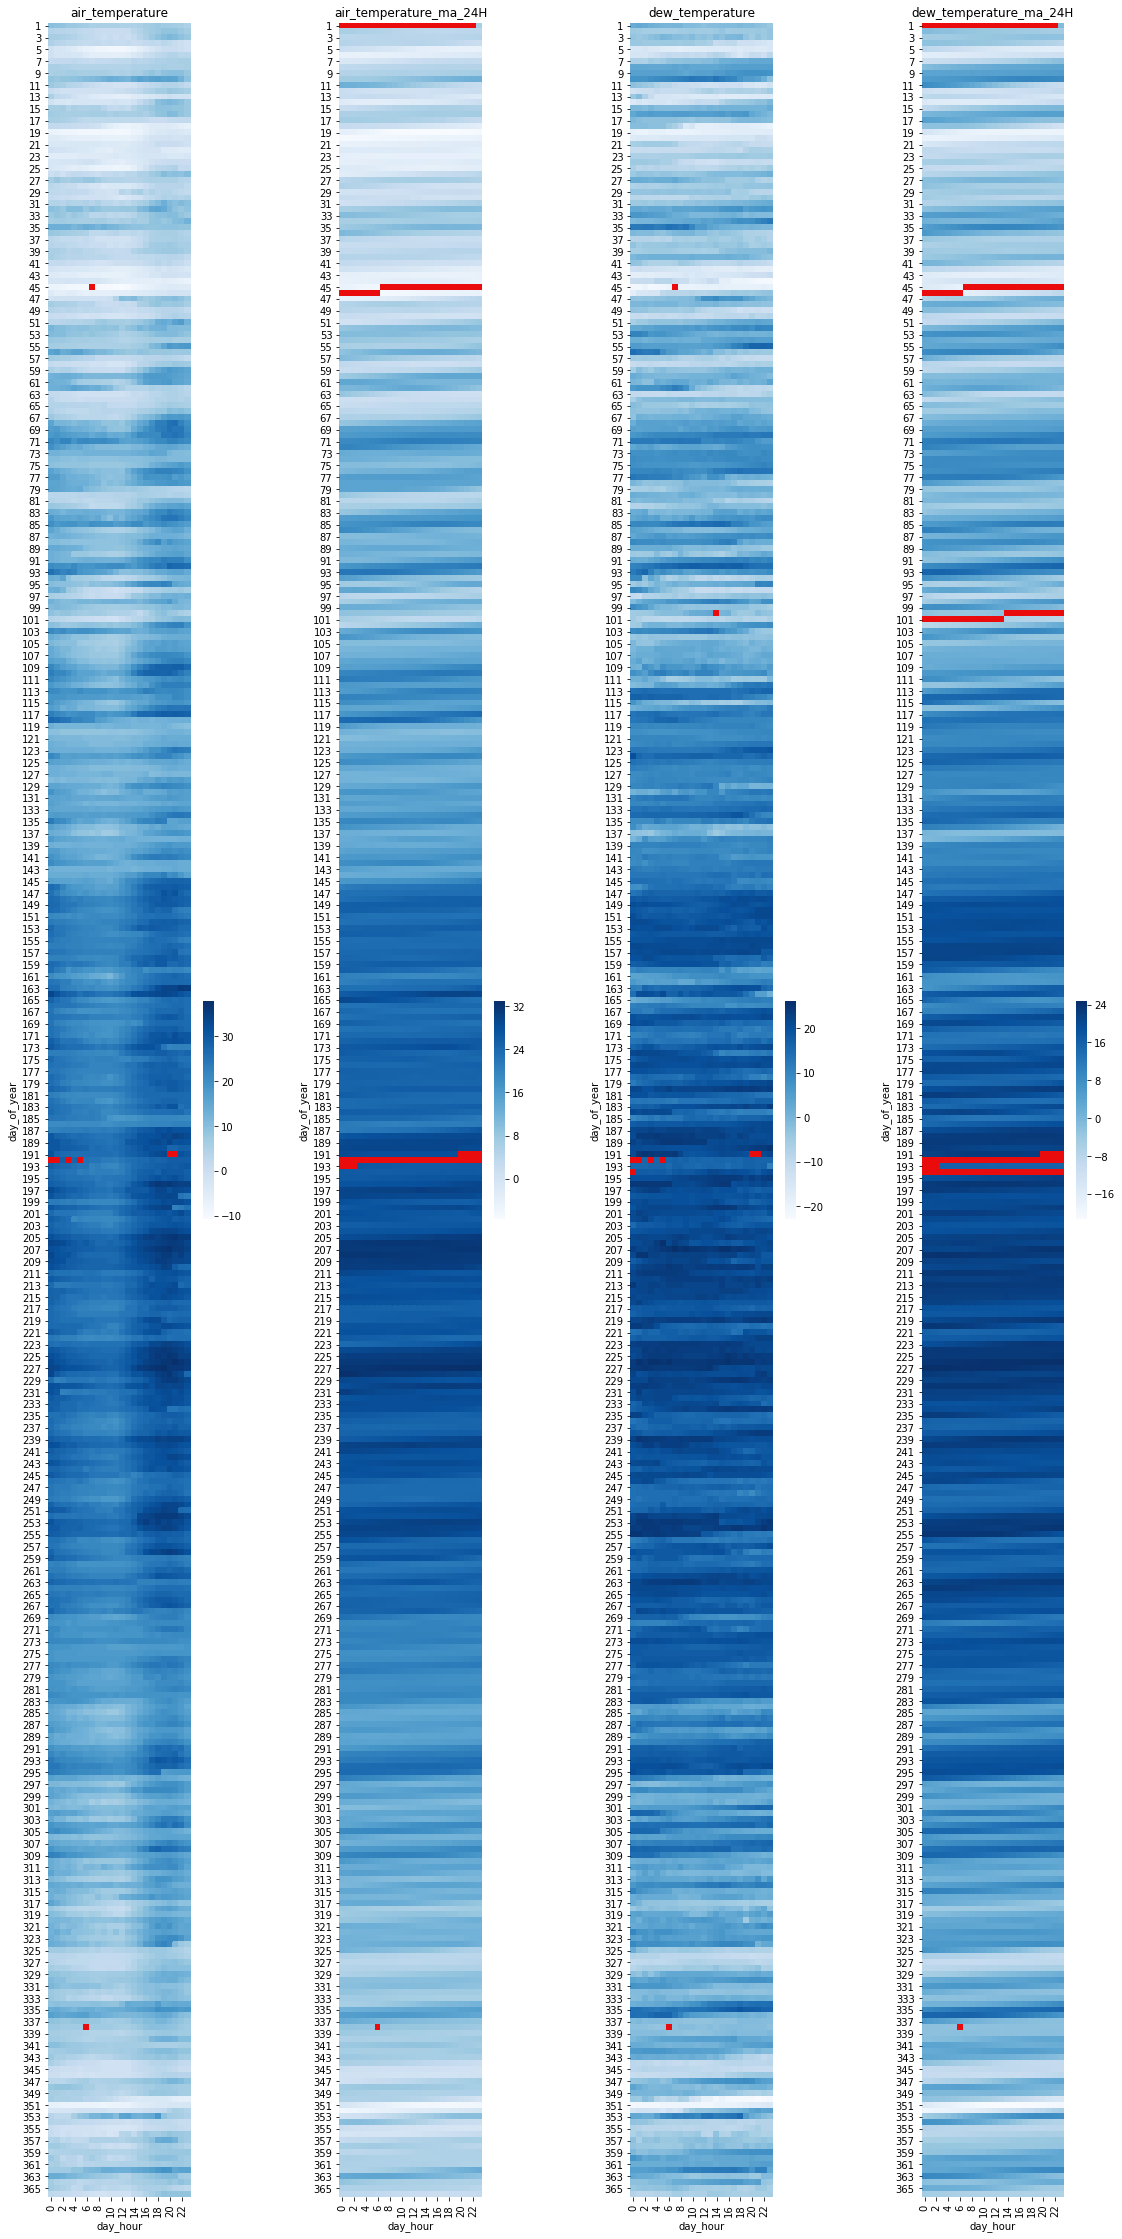

In [12]:
# Visualize missing data

n_maps = len(weather_features)

fig, axs = plt.subplots(nrows=1, ncols=n_maps, figsize=(5*n_maps, 40))

for i in range(n_maps):
    feature_i = weather_features[i]
    axs[i].set_title(feature_i)
    sns.heatmap(pivoted_features.get(feature_i), cmap='Blues', cbar_kws={"shrink": 0.1}, square=True, ax=axs[i])

Depending of wether the corresponding timestamp is present in the index before computing moving average features, any missing value in the raw data can generate a 24h missing gap in the averaging features. Then as any row with missing value in any used feature is deleted, it's great loss of data. We just have to interpolate the missing data to avoid those gaps.<br>
<br>
A one hour gap can be interpolated without problems, but we see 2h gaps also, and we could have wider gaps.
So we need to set a limit to the wideness of the gaps we are going to interpolate.<br>
We could visualize such interpolation results on 'fake' missing data intervals to see the quality of this interpolation in function of the wideness of the gap.<br>
<br>
We also note that the computation of averaged features induce missing datas on the first 24 hours, which could be avoided by computing on less points in this case.

In [13]:
# Let's work on air_temperature, april 1 to 20


In [34]:
def build_interpolation_method_stg(method_stg, order):
    if order == None:
        return method_stg
    else:
        return method_stg + '_' + str(order)

In [162]:
def perform_interpolation(df, col_name, timestamps, margin, interp_method, order):
    
    interp_method_stg = build_interpolation_method_stg(interp_method, order)
    print('perform interpolation : {}'.format(interp_method_stg))
    
    interp_values = []
    interp_errors = []
    
    for timestamp in timestamps[margin:-margin]:
                    
        df_to_interpolate = df.copy()
        df_to_interpolate.loc[timestamp, col_name] = np.nan

        if order != None:
            df_to_interpolate[col_name].interpolate(
                method=interp_method, 
                order=order, 
                inplace=True
            )
        else:
            df_to_interpolate[col_name].interpolate(
                method=interp_method, 
                inplace=True
            )

        interpolated_value = df_to_interpolate.loc[timestamp, col_name]
        truth = df.loc[timestamp, col_name]
        
        interp_values.append(interpolated_value)
        interp_errors.append(np.abs(interpolated_value-truth))
        
        
    df_interp_air_T_m = pd.DataFrame({
        'timestamp' : timestamps[margin:-margin], 
        col_name : interp_values,
        'interpolation_error' : interp_errors
    })
    df_interp_air_T_m['interpolation_method'] = interp_method_stg 

    print('{} done.'.format(interp_method_stg))
    
    return df_interp_air_T_m    

In [175]:
# parameters
interp_methods = {
    #'time' : None,
    'linear' : None,
    'polynomial' : [3, 5],
    'nearest' : None,
    'spline' : [3, 4, 5],
    
}

start_date = '2016-04-01'
end_date = '2016-04-20'

# the number of values that we don't interpolate at each extremity
margin = 5

# ----
# computations


df_air_T = b_df_weather[['air_temperature']].copy()

truth_values_df = df_air_T.loc[start_date : end_date].copy()
truth_values_df.reset_index(inplace=True)
truth_values_df['interpolation_error'] = 0.
truth_values_df['interpolation_method'] = 'ground_truth'

interp_tsps = truth_values_df['timestamp']

interpolation_dfs = [truth_values_df]

for (interp_method, interp_orders) in interp_methods.items():

    if interp_orders != None:
        for order in interp_orders:
            df_itpted = perform_interpolation(df_air_T, 'air_temperature', interp_tsps, margin, interp_method, order)
            interpolation_dfs.append(df_itpted)
        
    else:
        df_itpted = perform_interpolation(df_air_T, 'air_temperature', interp_tsps, margin, interp_method, None)
        interpolation_dfs.append(df_itpted)    

df_interp_air_T = pd.concat(interpolation_dfs)

perform interpolation : linear
linear done.
perform interpolation : polynomial_3
polynomial_3 done.
perform interpolation : polynomial_5
polynomial_5 done.
perform interpolation : nearest
nearest done.
perform interpolation : spline_3
spline_3 done.
perform interpolation : spline_4
spline_4 done.
perform interpolation : spline_5
spline_5 done.


In [176]:
df_interp_air_T.head()

,timestamp,air_temperature,interpolation_error,interpolation_method
0,2016-04-01 00:00:00,20.6,0.0,ground_truth
1,2016-04-01 01:00:00,20.0,0.0,ground_truth
2,2016-04-01 02:00:00,20.0,0.0,ground_truth
3,2016-04-01 03:00:00,19.4,0.0,ground_truth
4,2016-04-01 04:00:00,21.1,0.0,ground_truth


In [177]:
df_interp_air_T.tail()

,timestamp,air_temperature,interpolation_error,interpolation_method
470,2016-04-20 14:00:00,15.331119,0.268881,spline_5
471,2016-04-20 15:00:00,16.581789,0.118211,spline_5
472,2016-04-20 16:00:00,17.787754,0.012246,spline_5
473,2016-04-20 17:00:00,18.931277,0.631277,spline_5
474,2016-04-20 18:00:00,19.778598,0.378598,spline_5


In [178]:
df_interp_air_T['timestamp'].min()

Timestamp('2016-04-01 00:00:00')

In [179]:
n = 100
df_interp_air_T['timestamp'].min() + pd.Timedelta('' + str(n) + ' hour')

Timestamp('2016-04-05 04:00:00')

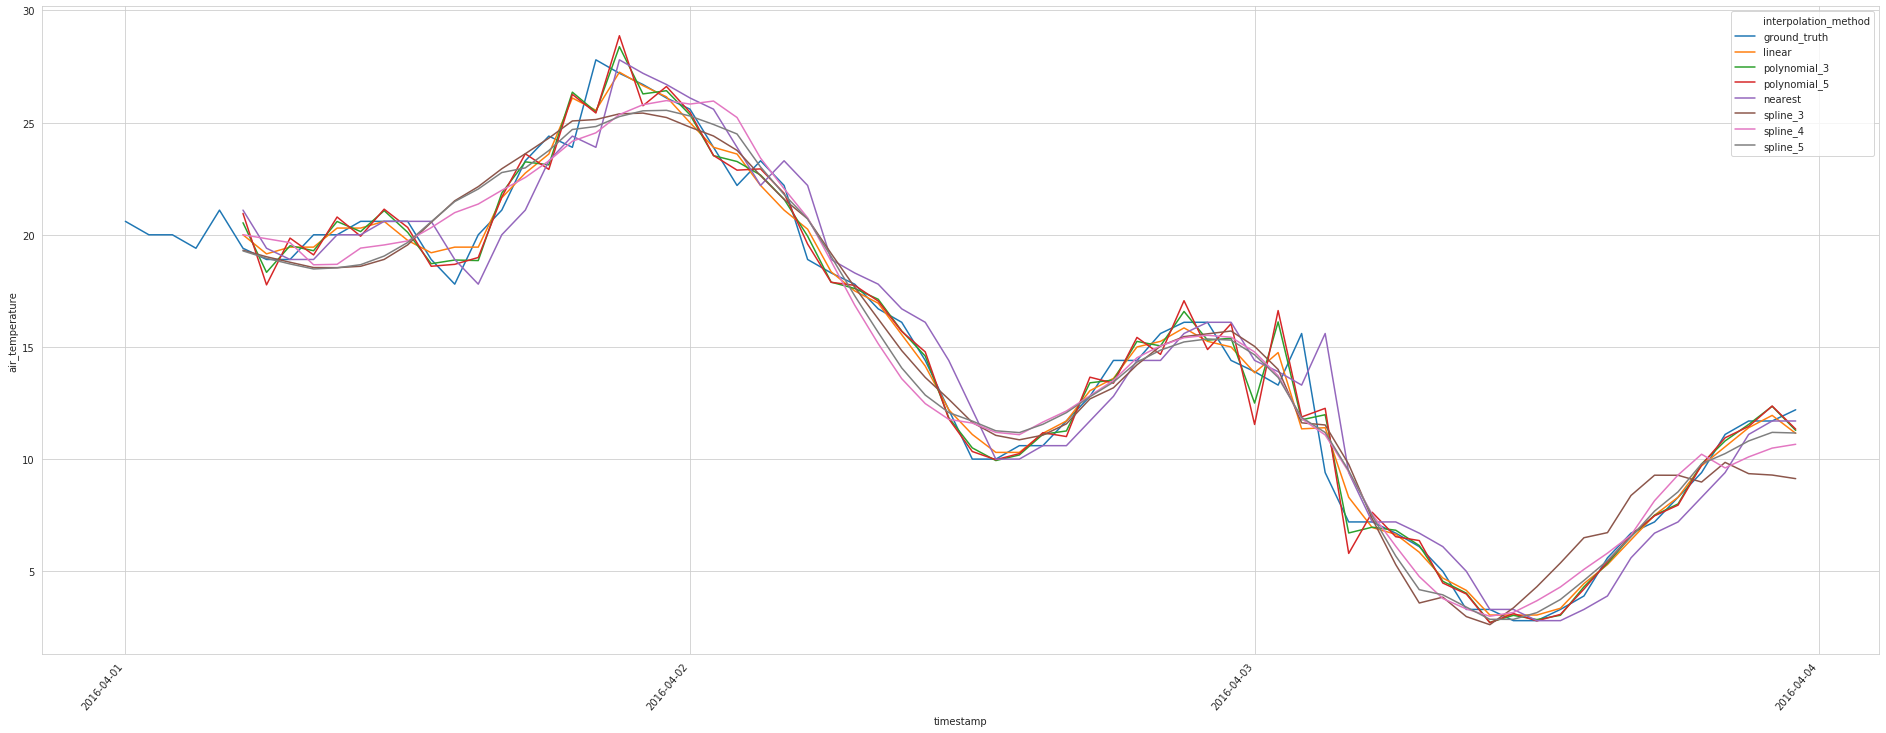

In [180]:
fig = plt.figure(figsize=(26, 10))

# max n_hours to plot
max_length = 72
max_date = df_interp_air_T['timestamp'].min() + pd.Timedelta('' + str(max_length) + ' hour')
capped_df_interp_air_T = df_interp_air_T[df_interp_air_T['timestamp'] < max_date]

with sns.axes_style("whitegrid"):
    ax = sns.lineplot(
        x='timestamp', 
        y='air_temperature', 
        hue='interpolation_method',
        data=capped_df_interp_air_T
    )
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.set_ylim(bottom=0., top=top)
    plt.xticks(rotation=50, horizontalalignment='right')
        
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)

In [181]:
df_no_gt = df_interp_air_T[df_interp_air_T['interpolation_method'] != 'ground_truth']

df_grouped_mean = df_no_gt.groupby('interpolation_method').mean().sort_values(by='interpolation_error')
df_grouped_mean.rename({'interpolation_error':'mean_interpolation_error'}, inplace=True, axis=1)
df_grouped_mean

,air_temperature,mean_interpolation_error
interpolation_method,,
linear,12.566489,0.458191
polynomial_3,12.565764,0.490523
polynomial_5,12.565911,0.582980
spline_5,12.556521,0.892065
spline_4,12.552660,0.946345
spline_3,12.564448,0.948292
nearest,12.567021,0.990000


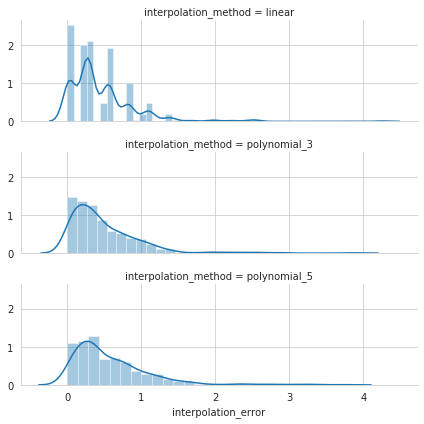

In [184]:
top_interp_methods = df_grouped_mean.index[0:3]

df_no_gt = df_interp_air_T[df_interp_air_T['interpolation_method'].isin(top_interp_methods)]

with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(df_no_gt, row='interpolation_method', height=2, aspect=3)
    g.map(sns.distplot, 'interpolation_error');

In [173]:
['ground_truth'] + top_interp_methods.tolist()

['ground_truth', 'linear', 'polynomial_3', 'polynomial_5']

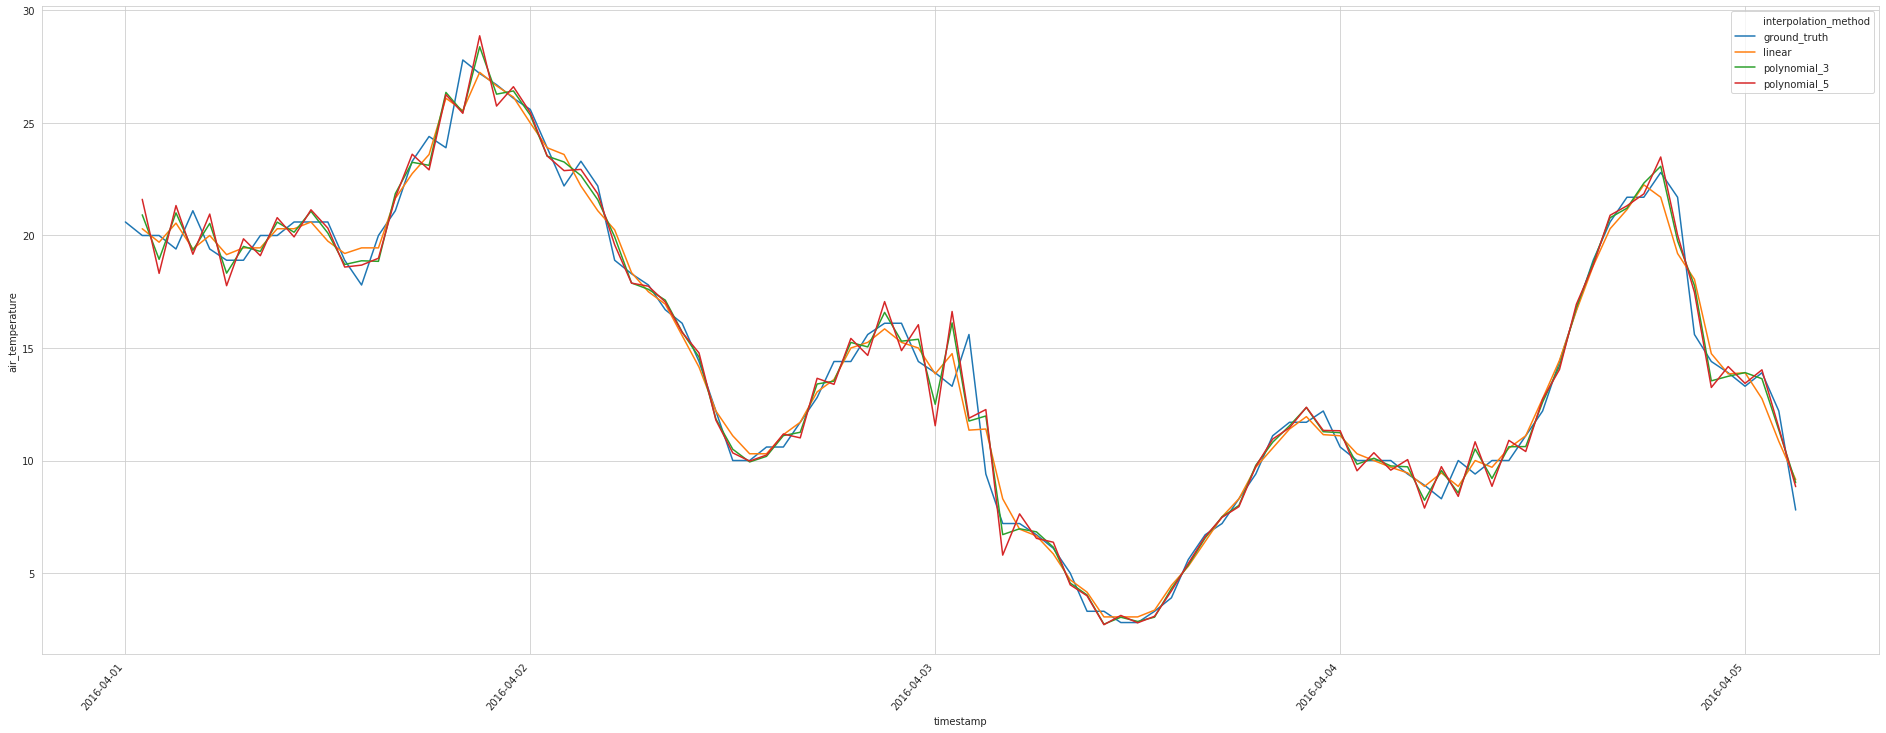

In [174]:
fig = plt.figure(figsize=(26, 10))
    
top_methods_with_truth = ['ground_truth'] + top_interp_methods.tolist()

# max n_hours to plot
max_length = 100

max_date = df_interp_air_T['timestamp'].min() + pd.Timedelta('' + str(max_length) + ' hour')
capped_df_interp_air_T = df_interp_air_T[df_interp_air_T['timestamp'] < max_date]
data = capped_df_interp_air_T[capped_df_interp_air_T['interpolation_method'].isin(top_methods_with_truth)]
    
with sns.axes_style("whitegrid"):
    ax = sns.lineplot(
        x='timestamp', 
        y='air_temperature', 
        hue='interpolation_method',
        data=data
    )
    ax.xaxis.set_major_locator(mdates.DayLocator())
    #ax.xaxis.set_minor_locator(mdates.DayLocator())
    #ax.set_ylim(bottom=0., top=top)
    plt.xticks(rotation=50, horizontalalignment='right')
        
plt.tight_layout(pad=0., w_pad=0., h_pad=2.)

<b>Conclusion :</b><br>For 1 consecutive missing value, linear interpolation performs best.<br>
Let's try for more missing values

In [50]:
def perform_interpolation(df, col_name, timestamps, margin, n_consecutive_missings, interp_method, order):
    
    